# Pneumonia Classification with VGG16

In this notebook, a dataset with chest x-ray images is used to train a VGG16 classification model to determine whether a patient has pneumonia.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Loading and Visualizing the Data](#2)
- [ 3 - Model](#3)
  - [ 3.1 VGG16](#3.1)
  - [ 3.2 Training](#3.2)
- [ 4 - Results](#4)

<a name="1"></a>
## 1 - Packages 

Below are all the needed packages for this notebook.
- [numpy](https://www.numpy.org) is the fundamental package for scientific computing with Python.
- [os](https://docs.python.org/3/library/os.html) is the python module that provides a portable way of using operating system dependent functionality.
- [cv2](https://opencv.org) is a computer vision library.
- [random](https://docs.python.org/3/library/random.html) is a module that implements pseudo-random number generators for various distributions.
- [matplotlib](https://matplotlib.org) is a comprehensive library for creating static, animated, and interactive visualizations in Python.
- [tensorflow](https://www.tensorflow.org) is an end-to-end machine learning platform.

In [1]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import sigmoid

<a name="2"></a>
## 2 - Loading and Visualizing the Data

The dataset contains thousands of high quality chest x-ray images labeled as normal or with pneumonia. These images were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

The dataset can be found here: [Chest X-Ray Images](https://data.mendeley.com/datasets/rscbjbr9sj/2)

In [2]:
#Get dataset paths
train_path = "./Data/train"
test_path = "./Data/test"
val_path = "./Data/val"

Let's view some of the images we will be working with.

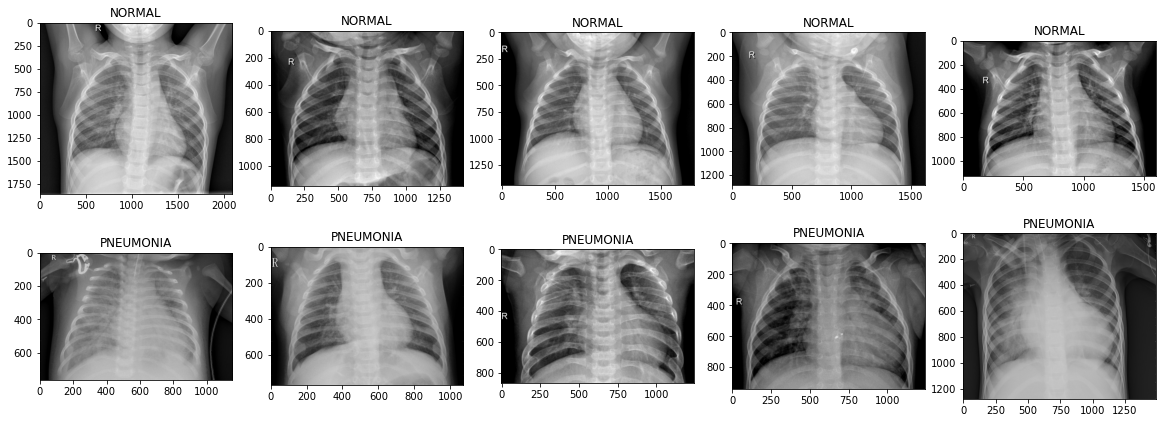

In [3]:
#Get first 5 images of each category
classes = ['NORMAL', 'PNEUMONIA']
plt.subplots(figsize=(20,7))
c = 1
for i in range(2):
    path = os.path.join(train_path, classes[i])
    for img in os.listdir(path):
        plt.subplot(2, 5, c)
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(img_array)
        plt.title(classes[i])
        c += 1
        if c == 6 or c== 11:
            break

It isn't clear (as a non medic) what the difference is between the normal images and the ones labeled with pneumonia. Let's now load our data for tensorflow and create a model.

In [4]:
#Load data
image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        class_mode='binary')

val_generator = data_generator.flow_from_directory(
        val_path,
        target_size=(image_size, image_size),
        class_mode='binary')

test_generator = data_generator.flow_from_directory(
        test_path,
        target_size=(image_size, image_size),
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


<a name="3"></a>
## 3 - Model

<a name="3.1"></a>
### 3.1 VGG16

Let's load the model with untrainable parameters.

In [5]:
#Load Model
base_model = VGG16(weights='imagenet')

In [6]:
#Create functiuonal model with no trainable parameters
base_model.trainable = False
base_model = Model(base_model.input, base_model.layers[-2].output)

In [7]:
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Now we can take the VGG16 model and create a functional model where we insert an output layer for our data. The output layer will be a Dense layer with a neuron as it will have a sigmoid activation.

In [8]:
#Create custom functional model
inputs = keras.Input(shape=(image_size, image_size, 3), dtype = tf.uint8)
x = base_model(inputs, training=False)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model (Functional)          (None, 4096)              134260544 
                                                                 
 dense (Dense)               (None, 1)                 4097      
                                                                 
Total params: 134,264,641
Trainable params: 4,097
Non-trainable params: 134,260,544
_________________________________________________________________


<a name="3.2"></a>
### 3.2 Training

With trainable parameters for our data, let's train the model.

In [10]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    batch_size = 32,
    validation_data = val_generator,
    epochs = 3
)

Epoch 1/3
163/163 [==============================] - 62s 355ms/step - loss: 0.2019 - accuracy: 0.9187 - val_loss: 0.6229 - val_accuracy: 0.7740
Epoch 2/3
163/163 [==============================] - 55s 336ms/step - loss: 0.1178 - accuracy: 0.9534 - val_loss: 0.6417 - val_accuracy: 0.7869
Epoch 3/3
163/163 [==============================] - 55s 338ms/step - loss: 0.0908 - accuracy: 0.9663 - val_loss: 0.4349 - val_accuracy: 0.8365


In [11]:
#Evaluate test data
model.evaluate(test_generator)

1/1 [==============================] - 0s 228ms/step - loss: 0.2796 - accuracy: 0.8750


[0.2796037793159485, 0.875]

<a name="4"></a>
## 4 - Results

Above, we can see the model was able to train the training set really well and obtain a good loss function of 0.43 and an accuracy of 0.83 for the validation data. Evaluating the test data also provided good results of 0.28 fo the loss function and an accuracy of 0.875. We have a good model.